<a href="https://colab.research.google.com/github/Katonokatono/Suicide/blob/model/Suicide_Detection_Tensorflow_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install wandb
!wandb login

wandb: Currently logged in as: kanoak (use `wandb login --relogin` to force relogin)


In [2]:
import tensorflow as tf
from tensorflow.python.distribute import distribution_strategy_context
from tensorflow.python.framework import ops
from tensorflow.python.framework import smart_cond
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import losses_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.utils.generic_utils import deserialize_keras_object
from tensorflow.python.keras.utils.generic_utils import serialize_keras_object
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops.losses import losses_impl
from tensorflow.python.ops.losses import util as tf_losses_util
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

In [3]:
import wandb
from wandb.keras import WandbCallback


In [4]:
# #Initialize wandb

# wandb.init(project='gpt3', entity='alpha-coders')
# config={  # and include hyperparameters and metadata
#                      "learning_rate": 0.005,
#                      "epochs": 5,
#                      "batch_size": 64,
#                      "loss_function": "sparse_categorical_crossentropy",
#                      "architecture": "RNN"}
# # 2. Save model inputs and hyperparameters
# config = wandb.config

In [5]:

# for i in range(10):
#   log_dict = {
#       "train_loss": 1/(i+1),
#       "custom_step": i**2,
#       "validation_loss": 1/(i+1) }
# wandb.log(log_dict)

In [6]:
wandb.config.dropout = 0.2

Modelling using Tensorflow hub using a pretrained word embedding layer to classify tweets on climate change into classes

In [7]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from spacy.lang.en import English
nlp = English()
import spacy
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and preview data

In [8]:
df = pd.read_csv('/content/final_data_suicide.csv')

In [9]:
df.head()

,Unnamed: 0,friends_count,followers_count,statuses_count,created_at,retweet_count,label,town,clean_text
0,1,182,83,6950,09/14/2021 7:47,0,anxiety,burundi,bunmo multi item stretchy string fidget toy pk...
1,2,983,915,12944,09/14/2021 7:31,0,anxiety,kenya,unkonfined basic motivation behind behavior bi...
2,3,281,63,290,09/14/2021 7:30,0,anxiety,nairobi,munenekimathi zablonorina bp normal yes check ...
3,4,220,2052,37982,09/14/2021 7:02,0,anxiety,nairobi kenya,deal anxious share experience anxiety yvonne m...
4,5,857,272,650,09/14/2021 7:00,2,general tweet,nairobi,know dry spell cause anxiety depression even s...


In [10]:
df.columns

Index(['Unnamed: 0', 'friends_count', 'followers_count', 'statuses_count',
       'created_at', 'retweet_count', 'label', 'town', 'clean_text'],
      dtype='object')

In [11]:
df.head()

,Unnamed: 0,friends_count,followers_count,statuses_count,created_at,retweet_count,label,town,clean_text
0,1,182,83,6950,09/14/2021 7:47,0,anxiety,burundi,bunmo multi item stretchy string fidget toy pk...
1,2,983,915,12944,09/14/2021 7:31,0,anxiety,kenya,unkonfined basic motivation behind behavior bi...
2,3,281,63,290,09/14/2021 7:30,0,anxiety,nairobi,munenekimathi zablonorina bp normal yes check ...
3,4,220,2052,37982,09/14/2021 7:02,0,anxiety,nairobi kenya,deal anxious share experience anxiety yvonne m...
4,5,857,272,650,09/14/2021 7:00,2,general tweet,nairobi,know dry spell cause anxiety depression even s...


In [12]:
#df.to_csv('clean classified data.csv')

In [13]:
df['label']

0             anxiety
1             anxiety
2             anxiety
3             anxiety
4       general tweet
            ...      
4167       depression
4168       depression
4169        awareness
4170    general tweet
4171       depression
Name: label, Length: 4172, dtype: object

In [14]:
df.dropna(inplace=True)

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])


vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

EDA

general tweet      2610
awareness           478
anxiety             357
depression          355
substance abuse     134
thoughts            129
stress              109
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'class size')

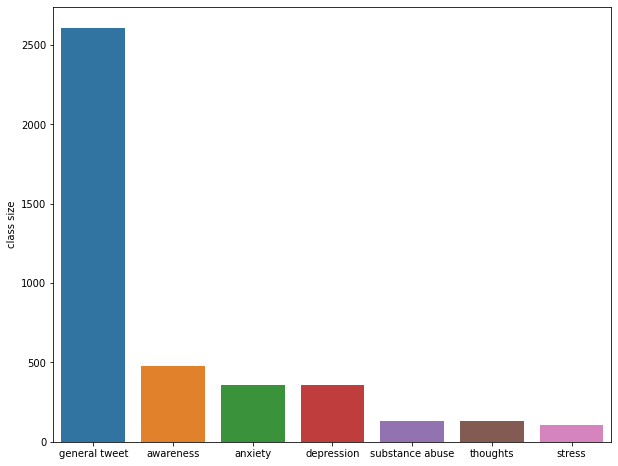

In [16]:
#check the class distriburion
import seaborn as sns
import matplotlib.pyplot as plt
print(df['label'].value_counts())
x=df['label'].value_counts()
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x.index,x)
plt.gca().set_ylabel('class size')

In [17]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# df['class1'] = le.fit_transform(df['class'])

In [18]:
! pip install wordcloud

In [19]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# wc = WordCloud()
# wc.generate(df.clean_text)
# plt.imshow(wc, interpolation="bilinear")
# plt.axis('off')
# plt.show()

## Dealing with class imbalance

In [20]:
import tensorflow as tf
import os
import datetime
import tensorflow_hub as hub
from __future__ import absolute_import,division,print_function,unicode_literals

In [21]:
# Get the counts of the target classes
df['label'].value_counts()

general tweet      2610
awareness           478
anxiety             357
depression          355
substance abuse     134
thoughts            129
stress              109
Name: label, dtype: int64

In [22]:
# We split the dataset to train and test datasets, 80/20 split 
X_train,X_test,y_train,y_test=train_test_split(df,df["label"],test_size=0.2,random_state=111,)

We are going to assign class weights to deal with imbalance. Due to the difference in each class, the algorithms tend to get biased towards the majority values present and don’t perform well on the minority values.

The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. 

In [23]:
# We compute classweights
from sklearn.utils import class_weight
class_weights=list(class_weight.compute_class_weight('balanced',np.unique(df['label']),df['label']))

In [24]:
# We sort the class weights 
class_weights.sort()
class_weights

[0.22835249042145594,
 1.2468619246861925,
 1.669467787114846,
 1.6788732394366197,
 4.447761194029851,
 4.62015503875969,
 5.467889908256881]

In [25]:
# we encode the target classes and assigning the class weights to each class index
weights={}
for index, weight in enumerate(class_weights):
  weights[index]=weight

In [26]:
weights

{0: 0.22835249042145594,
 1: 1.2468619246861925,
 2: 1.669467787114846,
 3: 1.6788732394366197,
 4: 4.447761194029851,
 5: 4.62015503875969,
 6: 5.467889908256881}

In [27]:
#  Check the columns
df.columns

Index(['Unnamed: 0', 'friends_count', 'followers_count', 'statuses_count',
       'created_at', 'retweet_count', 'label', 'town', 'clean_text'],
      dtype='object')

In [28]:
# Coverting the datasets into tensors. We feed the input X value and product
dataset_train=tf.data.Dataset.from_tensor_slices((X_train['clean_text'].values,X_train['label'].values))
dataset_test=tf.data.Dataset.from_tensor_slices((X_test['clean_text'].values,X_test['label'].values))

In [29]:
# Coverting the datasets into tensors. We feed the input X value and product
dataset_train=tf.data.Dataset.from_tensor_slices((X_train['clean_text'].values,X_train['label'].values))
dataset_test=tf.data.Dataset.from_tensor_slices((X_test['clean_text'].values,X_test['label'].values))

In [30]:
# Print text and target columns
for text, target in dataset_train.take(5):
  print('Tweet:{},Target:{}'.format(text,target))
print('************************')
for text, target in dataset_test.take(5):
  print('Tweet:{},Target:{}'.format(text,target))

Tweet:b'shed weight depression agoraphobia fuelprices bahati moses kuria kibaki bure k',Target:b'depression'
Tweet:b'poghie esquire say woman sport kenya best shot make u global house hold name chos',Target:b'general tweet'
Tweet:b'pulitzer kenny depress rain sound like sad weather',Target:b'depression'
Tweet:b'ehiga go nairobi woman adams one get isolation ward isolate home w',Target:b'general tweet'
Tweet:b'junetmohamed baba look tire depressed',Target:b'depression'
************************
Tweet:b'kalindamwene rugusuki absolutely exactly point except anxiety knowing',Target:b'general tweet'
Tweet:b'globally people die suicide year rate suicide men twice high compare',Target:b'awareness'
Tweet:b'chronic stress lead insomnia anxiety change appetite high blood pressure also cause grey accord',Target:b'anxiety'
Tweet:b'bunmo multi item stretchy string fidget toy pk calm sensory stretchy string anxiety relief item',Target:b'anxiety'
Tweet:b'dr eric njuguna psychiatrist globally kenya reg

In [31]:
df['label'].unique()

array(['anxiety', 'general tweet', 'awareness', 'depression',
       'substance abuse', 'thoughts', 'stress'], dtype=object)

In [32]:
# Convert target column from string to numerical using tensorflow lookup hash table
table=tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['general tweet', 'suicidal thoughts', 'awareness', 'anxiety',
       'depression', 'substance abuse', 'stress']),
        values=tf.constant([0,1,2,3,4,5,6]),
    ),
    default_value=tf.constant(-1),
    name='target_encoding'
)
@tf.function #converts regular python code to a callable Tensorflow graph function, 
              #which is usually more performant and python independent
def target(x):
  return table.lookup(x)

In [33]:
# Callable fi=unction that returns the class of text
def show_batch(dataset,size=5):
  for batch,label in dataset.take(size):
    print(batch.numpy())
    print(target(label).numpy())

In [34]:
show_batch(dataset_test,5)

b'kalindamwene rugusuki absolutely exactly point except anxiety knowing'
0
b'globally people die suicide year rate suicide men twice high compare'
2
b'chronic stress lead insomnia anxiety change appetite high blood pressure also cause grey accord'
3
b'bunmo multi item stretchy string fidget toy pk calm sensory stretchy string anxiety relief item'
3
b'dr eric njuguna psychiatrist globally kenya regard suicideover kenyan last thr'
0


We can print n-rows of target column and their target classes

In [35]:
# Creating a fetch function to pass and return text value as is. Also we one encode the target value
def fetch(text,labels):
  return text,tf.one_hot(target(labels),7)

In [36]:

# Map the fetch function to the train and test dataset 
train_data_f=dataset_train.map(fetch)
test_data_f=dataset_test.map(fetch)

In [37]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'shed weight depression agoraphobia fuelprices bahati moses kuria kibaki bure k'>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)>)

In [38]:
# Creates batches of tensors in tensors
train_data,train_labels=next(iter(train_data_f.batch(5)))
train_data,train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'shed weight depression agoraphobia fuelprices bahati moses kuria kibaki bure k',
        b'poghie esquire say woman sport kenya best shot make u global house hold name chos',
        b'pulitzer kenny depress rain sound like sad weather',
        b'ehiga go nairobi woman adams one get isolation ward isolate home w',
        b'junetmohamed baba look tire depressed'], dtype=object)>,
 <tf.Tensor: shape=(5, 7), dtype=float32, numpy=
 array([[0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>)

In [39]:
# Creating a embedding layer by using pretrained embedding layer to enable us to convert each word into a fixed length vector of defined size
embedding='https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
hub_layer=hub.KerasLayer(embedding,output_shape=[128],input_shape=[],
                        dtype=tf.string,trainable=True)# The output shape is 128
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.32690626, -0.04046366, -0.04208031, -0.10721476, -0.02498217,
        -0.0331523 , -0.21422257,  0.00561956, -0.09913614,  0.19483371,
         0.16916531,  0.1086879 ,  0.06891395,  0.01582433,  0.06246696,
        -0.22254592, -0.04703877, -0.06170458, -0.15699711, -0.20644449,
        -0.06947882, -0.03513756, -0.04203346, -0.12619421, -0.10642936,
        -0.01949831, -0.04432891,  0.12908904, -0.11591989, -0.15672106,
         0.14061436,  0.06818625,  0.05527182,  0.07663406, -0.03860941,
         0.00572619,  0.03424008, -0.02145527,  0.18746594,  0.00054167,
        -0.25896645, -0.18225539, -0.05943421,  0.05793254,  0.02453846,
         0.01659108,  0.04918219,  0.18786849, -0.03822126,  0.02699505,
         0.15340593, -0.02443002, -0.17780729, -0.08656345,  0.05898007,
         0.03575388, -0.10581801, -0.15648519, -0.10362724,  0.12447459,
         0.0636428 , -0.08365341, -0.03549648, -0.0189582 ,  0.12746353,
 

In [40]:
# We create a keras sequential model.
# Sequential groups a linear stack of layers into a tf.keras.Model.
# Sequential provides training and inference features on this model.

model=tf.keras.Sequential()
model.add(hub_layer)
for units in [128,128,64,32]:
  model.add(tf.keras.layers.Dense(units,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))

# We specify the output as 6 predicted values 
model.add(tf.keras.layers.Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [41]:
# #Initialize wandb

wandb.init(project='gpt3', entity='alpha-coders',save_code=True)
config={  # and include hyperparameters and metadata
                      "epochs": 10,
                      "batch_size": 512,
                      "architecture": "RNN",
                      "loss_function": "categorical_crossentropy",'sparcse'
                      'optimizer':'adam'}
# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.005

wandb: Currently logged in as: kanoak (use `wandb login --relogin` to force relogin)


In [42]:
# # Initialize wandb with your project name
# run = wandb.init(project='my-keras-integration',
#                  config={  # and include hyperparameters and metadata
#                      "learning_rate": 0.01,
#                      "epochs": 20,
#                      "batch_size": 128,
#                      "loss_function": "sparce categorical_crossentropy",
#                      "architecture": "RNN",
#                      "dataset": "df"
#                      })

In [43]:

# We compile using adam optimizer
config = wandb.config  # We'll use this to configure our experiment
tf.keras.backend.clear_session()

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(config.learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

We will evaluate the model using different metrics

In [44]:
# We shuffle and train the train and test data
train_data_f=train_data_f.shuffle(70000).batch(512)
test_data_f=test_data_f.batch(512)

In [45]:

# Create a copy of our model
model2=model

In [46]:
# we train the data using 10 epochs and using class weights. bias is therefore introduced to the model and computed.
# we will perform checks to ensure each class performs well
history=model.fit(train_data_f,epochs=10,
                  validation_data=test_data_f, 
                  verbose=2,
                  callbacks=[WandbCallback()])
#model.save(os.path.join(wandb.run.dir, "model.h5"))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


7/7 - 13s - loss: 1.5813 - recall: 0.1956 - val_loss: 1.1585 - val_recall: 0.5849
Epoch 2/10
7/7 - 11s - loss: 1.1433 - recall: 0.4456 - val_loss: 1.0370 - val_recall: 0.5663
Epoch 3/10
7/7 - 10s - loss: 0.9687 - recall: 0.5708 - val_loss: 0.9998 - val_recall: 0.4969
Epoch 4/10
7/7 - 11s - loss: 0.8353 - recall: 0.5757 - val_loss: 1.0792 - val_recall: 0.5564
Epoch 5/10
7/7 - 10s - loss: 0.7107 - recall: 0.6057 - val_loss: 1.1354 - val_recall: 0.5242
Epoch 6/10
7/7 - 11s - loss: 0.6065 - recall: 0.6338 - val_loss: 1.4597 - val_recall: 0.5948
Epoch 7/10
7/7 - 10s - loss: 0.5035 - recall: 0.7135 - val_loss: 1.7548 - val_recall: 0.6146
Epoch 8/10
7/7 - 10s - loss: 0.4507 - recall: 0.7701 - val_loss: 1.6914 - val_recall: 0.6109
Epoch 9/10
7/7 - 10s - loss: 0.3799 - recall: 0.8149 - val_loss: 2.0532 - val_recall: 0.6394
Epoch 10/10
7/7 - 10s - loss: 0.3628 - recall: 0.8328 - val_loss: 2.0143 - val_recall: 0.6221


In [47]:
loss, accuracy = model.evaluate(dataset_test.map(fetch).batch(1121),verbose=2)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})



1/1 - 0s - loss: 2.0143 - recall: 0.6221
Test Error Rate:  37.79


In [48]:
# check the length of the test dataset
len(list(dataset_test))



835

In [49]:
# craete a batch of the dataset and pass the model through entire dataset
results=model.evaluate(dataset_test.map(fetch).batch(1121),verbose=2)
print(results)

# we pass model through the test data and map the fetch function.
test_data,test_labels=next(iter(dataset_test.map(fetch).batch(10000)))
# Predict the target class
y_pred=model.predict(test_data)
# Check the model performance using classification and confusion matrix

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1))))
print('The accuracy of the model is ',metrics.accuracy_score(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))
print('The F1 score is: ',metrics.f1_score(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1),average='weighted'))
print('The recall score is ',metrics.recall_score(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1),average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))
print('\n', 'Classification report')
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

1/1 - 0s - loss: 2.0143 - recall: 0.6221
[2.0142822265625, 0.6220570206642151]
Mean Absolute Error: 0.9065868263473054
Mean Squared Error: 3.0431137724550896
Root Mean Squared Error: 1.7444522843732613
The accuracy of the model is  0.6778443113772455
The F1 score is:  0.6546860077602723
The recall score is  0.6778443113772455

 Confusion matrix
[[455  40  28  17   0   0]
 [ 62  44   1   7   0   0]
 [ 18   5  31   9   0   0]
 [ 21   8   5  36   0   0]
 [ 19   8   0   1   0   0]
 [ 11   3   3   3   0   0]]

 Classification report
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       540
           2       0.41      0.39      0.40       114
           3       0.46      0.49      0.47        63
           4       0.49      0.51      0.50        70
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        20

    accuracy                           0.68       835
   macro avg       0.36      0.3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy of the model is 83%

In [50]:
# we pass model through the test data and map the fetch function.
test_data,test_labels=next(iter(dataset_test.map(fetch).batch(10000)))


In [51]:
# Predict the target class
y_pred=model.predict(test_data)
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       540
           2       0.41      0.39      0.40       114
           3       0.46      0.49      0.47        63
           4       0.49      0.51      0.50        70
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        20

    accuracy                           0.68       835
   macro avg       0.36      0.37      0.36       835
weighted avg       0.63      0.68      0.65       835



In [52]:
from sklearn.metrics import classification_report

In [53]:
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       540
           2       0.41      0.39      0.40       114
           3       0.46      0.49      0.47        63
           4       0.49      0.51      0.50        70
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        20

    accuracy                           0.68       835
   macro avg       0.36      0.37      0.36       835
weighted avg       0.63      0.68      0.65       835



In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1))

array([[455,  40,  28,  17,   0,   0],
       [ 62,  44,   1,   7,   0,   0],
       [ 18,   5,  31,   9,   0,   0],
       [ 21,   8,   5,  36,   0,   0],
       [ 19,   8,   0,   1,   0,   0],
       [ 11,   3,   3,   3,   0,   0]])

The accuracy is accuracy score is 84%, 